In [ ]:
!pip install umap

In [ ]:
!pip install umap-learn


In [ ]:
!pip install bertopic

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re

In [5]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters

    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods

        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)

        processed_texts = [self.preprocess_text(text) for text in texts]

        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")

    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)

        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]

        return labels, cluster_terms

    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)

        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )

        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)

        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]

        return labels, topic_terms

    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)

        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]

        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)

        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])

        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)

        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]

        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)

        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }

        return cluster_stats

In [6]:
# Prepare your data
products_df = pd.read_csv('pet_supplies_cleaned.csv')
texts = products_df['title'] + ' ' + products_df['description']

In [7]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 200)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='bert_topic')

2025-02-21 23:21:47,488 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-21 23:22:30,566 - BERTopic - Dimensionality - Completed ✓
2025-02-21 23:22:30,570 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-21 23:22:31,137 - BERTopic - Cluster - Completed ✓
2025-02-21 23:22:31,169 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-21 23:22:33,081 - BERTopic - Representation - Completed ✓


In [9]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [10]:
# Number of total products
products_df.shape[0]

12262

In [11]:
# Number of clusters
len(cluster_stats)

80

In [12]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 846
Key Terms: toy, toys, ball, chew, kong

Cluster Size: 605
Key Terms: bed, washable, pet, beds, foam

Cluster Size: 437
Key Terms: harness, vest, pull, reflective, walking

Cluster Size: 394
Key Terms: collar, collars, adjustable, buckle, nylon

Cluster Size: 379
Key Terms: bowl, bowls, stainless, steel, feeder

Cluster Size: 345
Key Terms: shampoo, skin, coat, spray, bees

Cluster Size: 334
Key Terms: catit, catnip, senses, cat, toy

Cluster Size: 279
Key Terms: rawhide, chews, treats, chew, beef

Cluster Size: 241
Key Terms: playpen, crate, cage, hamster, guinea

Cluster Size: 209
Key Terms: carrier, travel, backpack, airline, approved



In [13]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

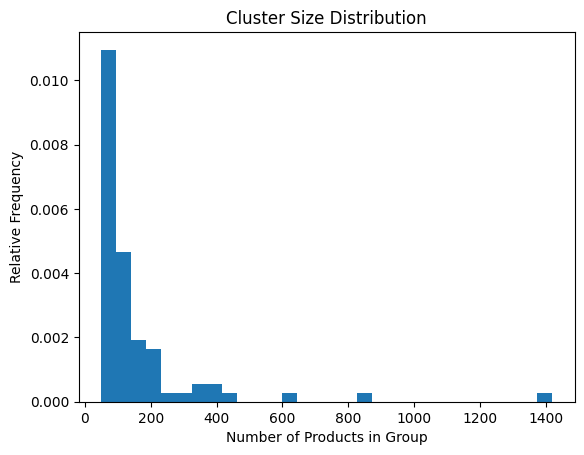

In [14]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [15]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

,count
label,
-1,1420
0,846
1,605
2,437
3,394


In [16]:
# Largest Group Info
cluster_stats[1]

{'size': 605,
 'terms': ['bed', 'washable', 'pet', 'beds', 'foam'],
 'sample_products': ['Downtown Pet Supply Thermal Cat Bed - Insulated Cat Mat with Aluminum Film & Sherpa Backing - Washer Safe Faux Fur Cover - Self-Warming Nap - Connectable, Regular - Animal Print Beige - 23 x 19in []',
  'Washable Dog Bed Deluxe Plush Dog Crate Beds Fulffy Comfy Kennel Pad Anti-Slip Pet Sleeping Mat for Large, Jumbo, Medium, Small Dogs Breeds, 23" x 18", Gray []',
  'Furhaven 44" Round Cooling Gel Foam Dog Bed Microvelvet Snuggery w/ Removable Washable Cover - Silver, 44-inch [\'Cozy comfort with a cooling twist! Pets who love to burrow under the covers enjoy the Furhaven Microvelvet Snuggery Dog Bed. This bed features a soft extra layer of fabric over the sleep surface that can be used as traditional burrow "blanket" or (by inserting the provided flexible hoop) as a private "cave" for your pet. Private, snuggly and stylish, the soft microvelvet fabric will blanket your pet in comfort while the coo

In [17]:
for i in range(len(cluster_stats)-1):
    print(cluster_stats[i]['terms'])

['toy', 'toys', 'ball', 'chew', 'kong']
['bed', 'washable', 'pet', 'beds', 'foam']
['harness', 'vest', 'pull', 'reflective', 'walking']
['collar', 'collars', 'adjustable', 'buckle', 'nylon']
['bowl', 'bowls', 'stainless', 'steel', 'feeder']
['shampoo', 'skin', 'coat', 'spray', 'bees']
['catit', 'catnip', 'senses', 'cat', 'toy']
['rawhide', 'chews', 'treats', 'chew', 'beef']
['playpen', 'crate', 'cage', 'hamster', 'guinea']
['carrier', 'travel', 'backpack', 'airline', 'approved']
['kaytee', 'hay', 'bird', 'birds', 'guinea']
['scratching', 'tree', 'post', 'tower', 'cat']
['leash', 'handle', 'lead', 'reflective', 'padded']
['joint', 'glucosamine', 'supplement', 'chondroitin', 'msm']
['treats', 'natural', 'we', 'ingredients', 'jerky']
['her', 'cat', 'wet', 'treats', 'feast']
['aquarium', 'tank', 'fish', 'led', 'glofish']
['litter', 'box', 'pan', 'cat', 'liners']
['sweater', 'winter', 'clothes', 'warm', 'jacket']
['miracle', 'odor', 'nature', 'stain', 'wipes']
['fluval', 'filter', 'media', 

In [18]:
cluster_terms = {i: cluster_stats[i]['terms'] for i in range(-1, len(cluster_stats)-1)}

In [20]:
import json

In [21]:
with open("pet_supplies_key_terms.json", "w") as f:
    json.dump(cluster_terms, f)

In [22]:
products_df.to_csv("pet_supplies_products.csv", index=False)